In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from scipy.stats import t, sem
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(grid)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [6]:
eval_er = read_csv(join(empo3_dir, 'eval_taxa_er.tsv'), sep='\t')

In [7]:
folds = folds.set_index(['sample type', 'sample'])
eval_er = eval_er.join(folds, ['sample type', 'sample'])

In [8]:
level7 = eval_er[(eval_er['level'] == 7) | (eval_er['level'] == 6)]
level7 = level7[(level7['class weights'] == 'average') |
                (level7['class weights'] == 'bespoke70') |
                (level7['class weights'] == 'uniform70')]

In [9]:
grouped = level7.groupby(['sample type', 'class weights', 'fold', 'level'])
def weighted_stats(x):
    errors = x['errors'].sum()
    abundance = x['reads'].sum()
    return Series([errors/abundance], index=['mean'])
figure2 = grouped.apply(weighted_stats)
figure2.reset_index(inplace=True)

In [10]:
grouped = figure2.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    #lower, upper = t.interval(0.95, 5, mu, se)
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure2 = grouped.apply(weighted_stats)
figure2.reset_index(inplace=True)

In [11]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Other'] * 14 + ['Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['sample type'] == old, 'sample type'] = new
for old, new in zip((6, 7), ('Genus', 'Species')):
    figure2.loc[figure2['level'] == old, 'level'] = new

In [12]:
figure2

,sample type,class weights,level,mean,lower,upper
0,Animal corpus,Average,Genus,0.166820,0.159108,0.174532
1,Animal corpus,Average,Species,0.207279,0.197687,0.216871
2,Animal corpus,Bespoke,Genus,0.141114,0.131366,0.150862
3,Animal corpus,Bespoke,Species,0.165921,0.155551,0.176292
4,Animal corpus,Uniform,Genus,0.216623,0.208643,0.224602
5,Animal corpus,Uniform,Species,0.303172,0.293345,0.312999
6,Animal distal gut,Average,Genus,0.143288,0.141515,0.145061
7,Animal distal gut,Average,Species,0.176981,0.174568,0.179394
8,Animal distal gut,Bespoke,Genus,0.134773,0.133781,0.135765
9,Animal distal gut,Bespoke,Species,0.163098,0.160789,0.165407


In [21]:
%%R -i figure2
figure2$sample.type <- factor(figure2$sample.type, levels=c(
 'Water (saline)',
 'Surface (saline)',
 'Sediment (saline)',
 'Water (non-saline)',
 'Surface (non-saline)',
 'Soil (non-saline)',
 'Sediment (non-saline)',
 'Plant rhizosphere',
 'Plant corpus',
 'Animal surface',
 'Animal secretion',
 'Animal proximal gut',
 'Animal distal gut',
 'Animal corpus'))
figure2$class.weights <- factor(figure2$class.weights, levels=c(
    'Uniform', 'Average', 'Bespoke'
))
figure2$fill <- paste(figure2$level, figure2$class.weights)
figure2$fill <- factor(figure2$fill, levels=c(
  'Species Uniform',
  'Species Average',
  'Species Bespoke',
  'Genus Uniform',
  'Genus Average',
  'Genus Bespoke'))
fillPalette <- c("#56B4E9", "#009E73", "#E69F00", "#D4ECF9", "#BFE6DC", "#F8E7BF")
colourPalette <- c("#56B4E9", "#009E73", "#E69F00", "#56B4E9", "#009E73", "#E69F00")
ggplot(data=figure2, aes(x=sample.type, y=mean*100)) +
  geom_col(data=figure2[figure2$level == 'Species',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_col(data=figure2[figure2$level == 'Genus',], width=0.8, position=position_dodge(width=0.9),
           aes(colour=fill, fill=fill)) +
  geom_errorbar(data=figure2[figure2$level == 'Species',],
                aes(ymin=lower*100, ymax=upper*100, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  geom_errorbar(data=figure2[figure2$level == 'Genus',],
                aes(ymin=lower*100, ymax=upper*100, fill=fill),
                width=0.4, position=position_dodge(width=0.9), alpha=0.5) +
  coord_flip(clip="off") +
  theme_bw() +
  labs(x='EMPO3 Habitat', y='Error Rate (%)') +
  scale_fill_manual(name='Level & Weights', values=fillPalette) +
  scale_colour_manual(name='Level & Weights', values=colourPalette) +
  theme(plot.margin = unit(c(1, 1, 2, 1), "lines"),
        axis.text.y = element_text(angle = 45)) +
  annotation_custom(
    grob=grid::textGrob(label = "Better Performance"),
    xmin=-0.5, xmax=-0.5, ymin=20, ymax=20
  ) + 
  annotation_custom(
    grob=linesGrob(arrow=arrow(type="open", ends="first", length=unit(2,"mm"))), 
    xmin=-0.3, xmax=-0.3, ymin=0., ymax=38
  )

ggsave(file="bc-figure1-error-rate.png", width=5, height=10, dpi=300)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  Ignoring unknown aesthetics: fill

  warnings.warn(x, RRuntimeWarning)


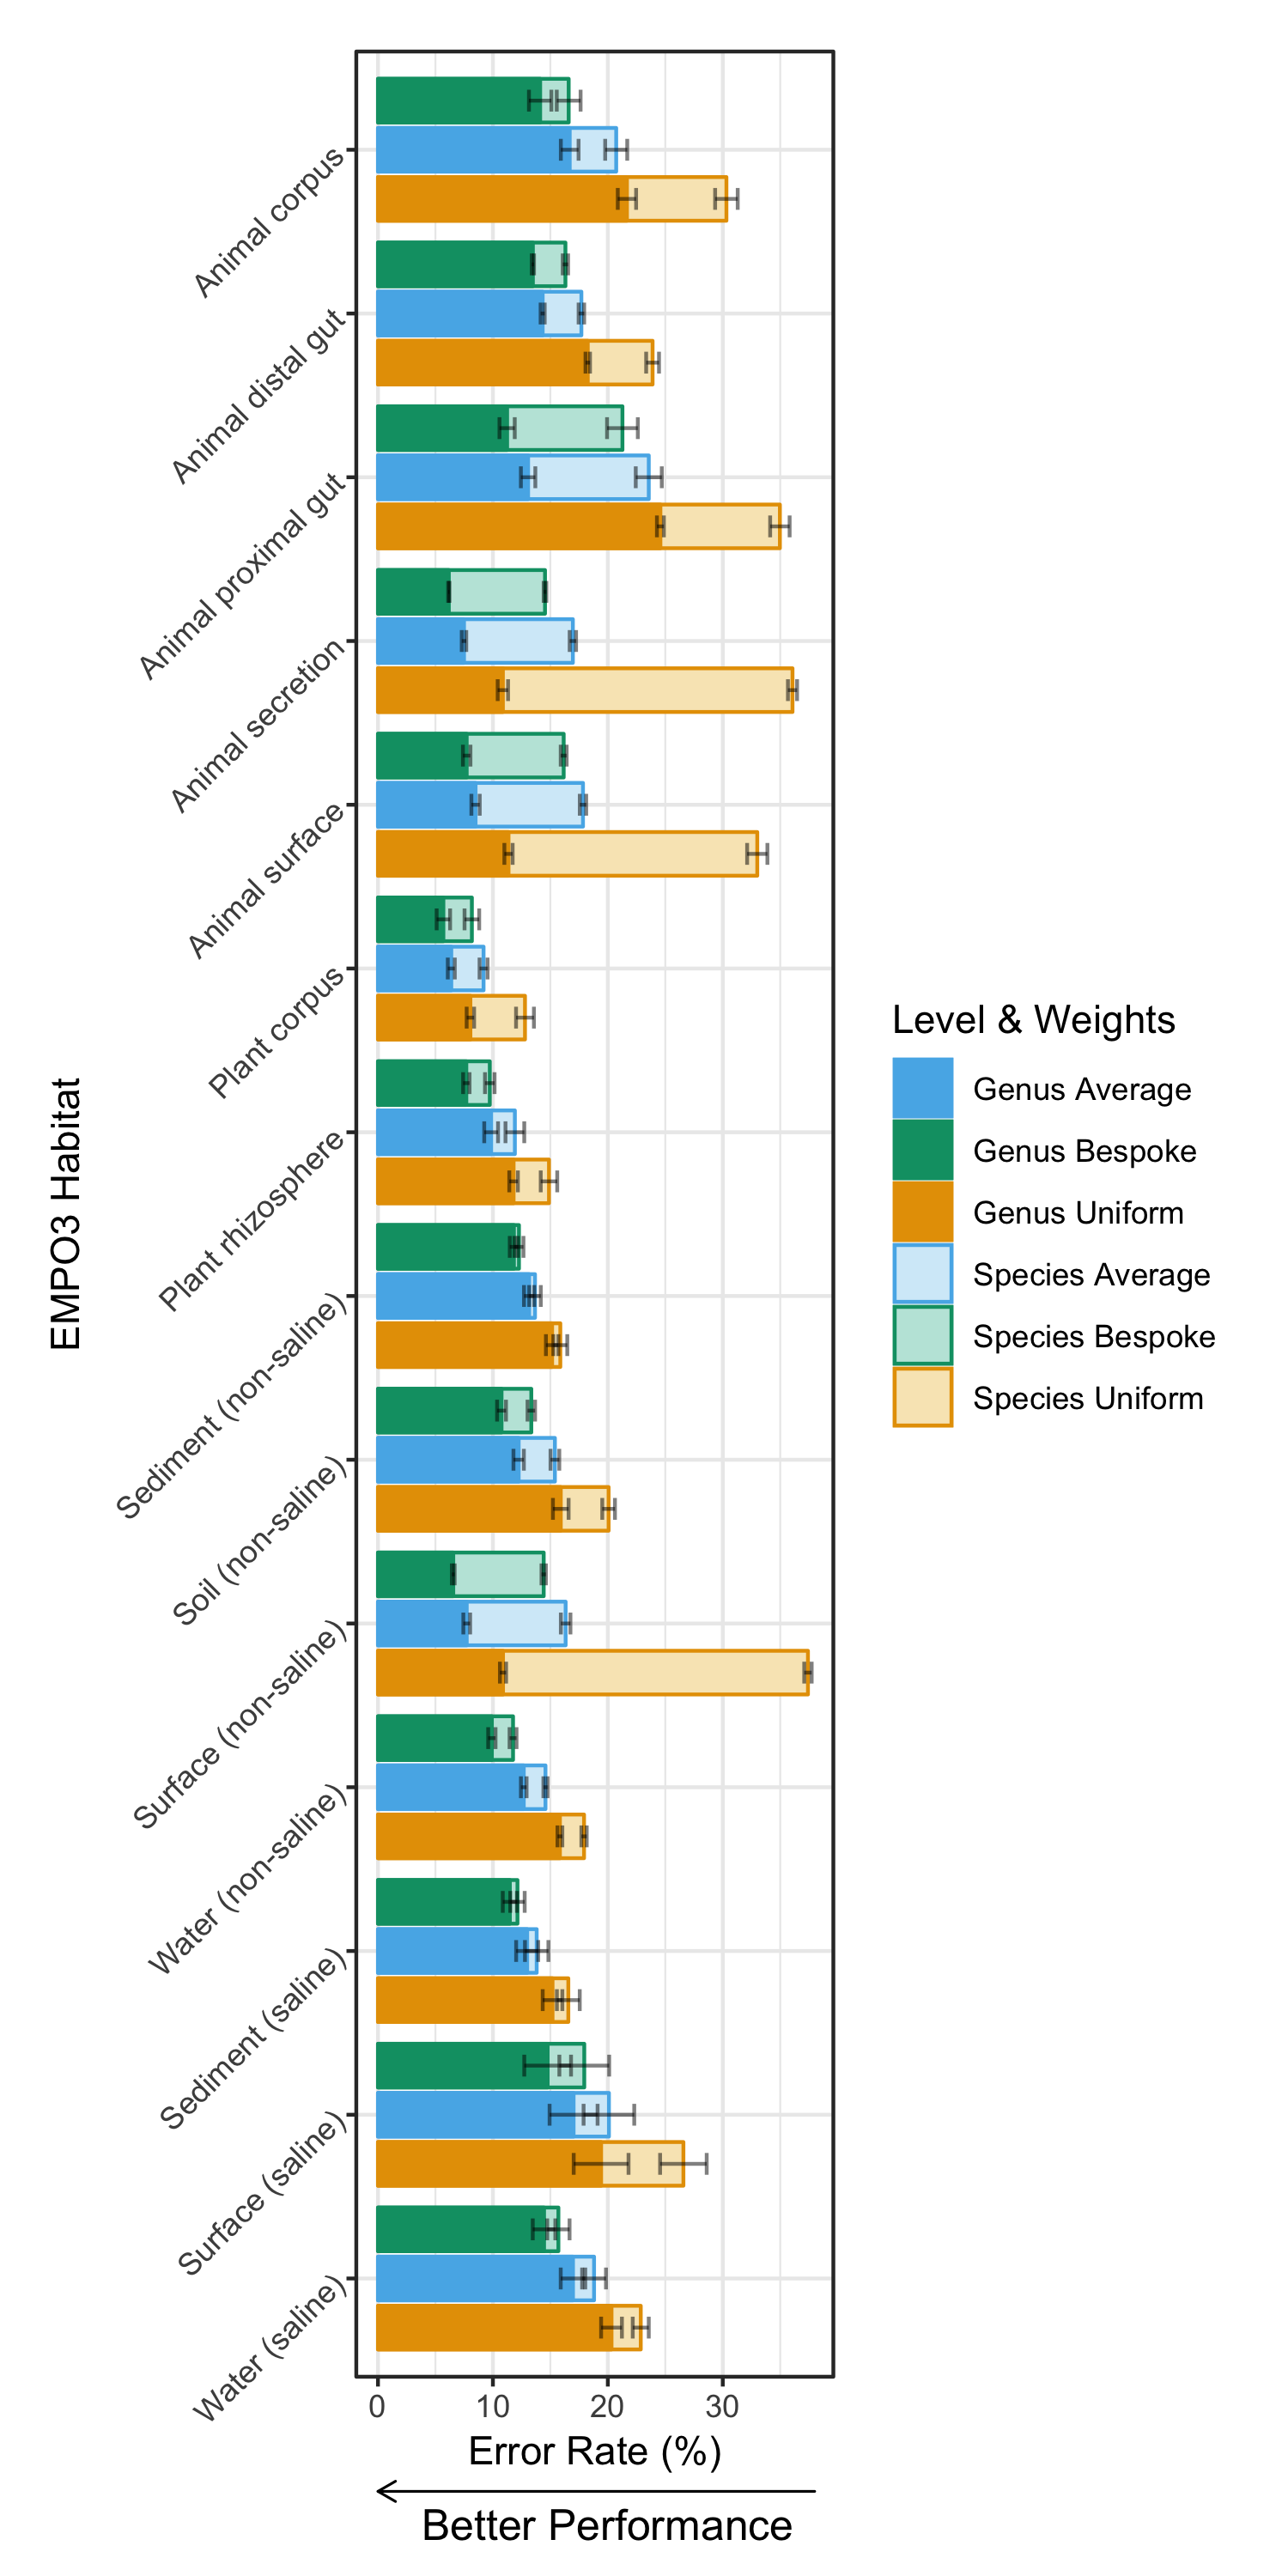

In [22]:
Image("bc-figure1-error-rate.png")